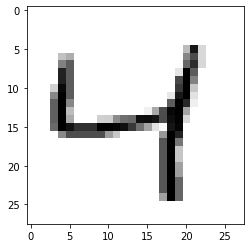

In [9]:
import data
import matplotlib.pyplot as plt


loader_train, loader_test = data.get_dataloaders(512)
plt.imshow(loader_train.dataset[2][0].squeeze(), cmap="gray_r")

In [10]:
from torch import nn
from copy import deepcopy

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self._flatten = nn.Flatten()
        self._model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.Linear(32, 10)
        )
        self._flatten.requires_grad_(False)
        self._model.requires_grad_(False)
        self.requires_grad_(False)

    def forward(self, x):
        return self._model(self._flatten(x))

    def child(self, std_dev: float) -> 'Model':
        child = deepcopy(self)
        for p in self.parameters():
            p.add_(torch.randn(p.size()) * std_dev)
        return child


In [11]:
import torch
from tqdm.notebook import tqdm
from typing import List, Tuple


loss_function = nn.CrossEntropyLoss()
loss_function.requires_grad_(False)
num_parents = 4
mutation_per_parent = 4
std_dev = 0.1


def train(candidates: List[Model]) -> List[Model]:
    with tqdm(desc="Batch", total=len(loader_train)) as pbatch:
        for (X, y) in loader_train:
            candidates.extend(
                [parent.child(std_dev) for parent in candidates for _ in range(mutation_per_parent)]
            )
            eval_candidates = [(candidate, loss_function(candidate(X), y).item()) for candidate in candidates]
            eval_candidates.sort(key=lambda c: c[1])

            candidates = list(map(lambda c: c[0], eval_candidates[0:num_parents]))
            pbatch.set_postfix(lowest_loss=eval_candidates[0][1])
            pbatch.update()

    return candidates

@torch.no_grad()
def test(model: Model) -> Tuple[float, float]:
    test_loss = 0.0
    accuracy = 0.0
    for X, y in loader_test:
        pred = model(X)
        test_loss += loss_function(pred, y).item()
        accuracy += (torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)).type(torch.float).sum()
    test_loss /= len(loader_test)
    accuracy /= len(loader_test.dataset)
    return test_loss, accuracy.item() 

In [12]:
import torch
from tqdm.notebook import trange


torch.manual_seed(666)
candidates = [Model() for _ in range(num_parents)]
with trange(1, 51, desc="Epoch") as pepoch:
    for epoch in pepoch:
        candidates = train(candidates)
        model = candidates[0]
        test_loss, accuracy = test(model)
        pepoch.set_postfix(loss=test_loss, accuracy=accuracy)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]

Batch:   0%|          | 0/118 [00:00<?, ?it/s]